# GROUP 35 (NEW YORK MARKET) FINAL SUMMATIVE GROUP PROJECT

## Importing Relevant Python Libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set dark background for plots
plt.style.use('dark_background')

## Drive Mount

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
--2024-08-05 00:07:33--  https://raw.githubusercontent.com/nanadotam/ITAI/main/Final-Project/ICCO_daily_prices.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401764 (392K) [text/plain]
Saving to: ‘/content/ICCO_daily_prices.csv’

/content/ICCO_daily 100%[===================>] 392.35K  --.-KB/s    in 0.04s   

2024-08-05 00:07:33 (8.90 MB/s) - ‘/content/ICCO_daily_prices.csv’ saved [401764/401764]



## Save Dataset To Your Google Drive

In [ ]:
# Download the dataset
!wget -O /content/ICCO_daily_prices.csv 'https://raw.githubusercontent.com/nanadotam/ITAI/main/Final-Project/ICCO_daily_prices.csv'

## Load Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('/content/ICCO_daily_prices.csv')
df = df.iloc[0:7662]

## Data Preprocessing

In [ ]:
# Convert 'Date' column to datetime without specifying a format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Convert price columns to numeric (remove any commas and convert to float)
price_columns = ['London futures (£ sterling/tonne)', 'New York futures (US$/tonne)',
                 'ICCO daily price (US$/tonne)', 'ICCO daily price (Euro/tonne)']

for col in price_columns:
    df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')

# Calculate Simple Moving Averages
df['MA_7'] = df['ICCO daily price (US$/tonne)'].rolling(window=7).mean()
df['MA_30'] = df['ICCO daily price (US$/tonne)'].rolling(window=30).mean()
df['MA_90'] = df['ICCO daily price (US$/tonne)'].rolling(window=90).mean()

# Calculate daily price differences
df['Price_Diff'] = df['ICCO daily price (US$/tonne)'].diff()

# Calculate volatility measures
df['Volatility_7'] = df['ICCO daily price (US$/tonne)'].rolling(window=7).std()
df['Volatility_30'] = df['ICCO daily price (US$/tonne)'].rolling(window=30).std()
df['Volatility_90'] = df['ICCO daily price (US$/tonne)'].rolling(window=90).std()

# Drop rows with NaN values generated by moving averages and price differences
df = df.dropna()

## Data Visualization

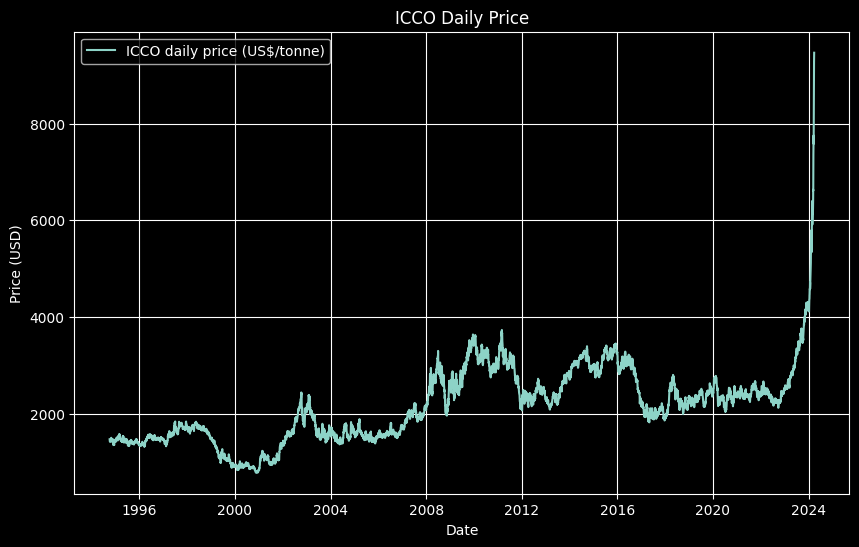

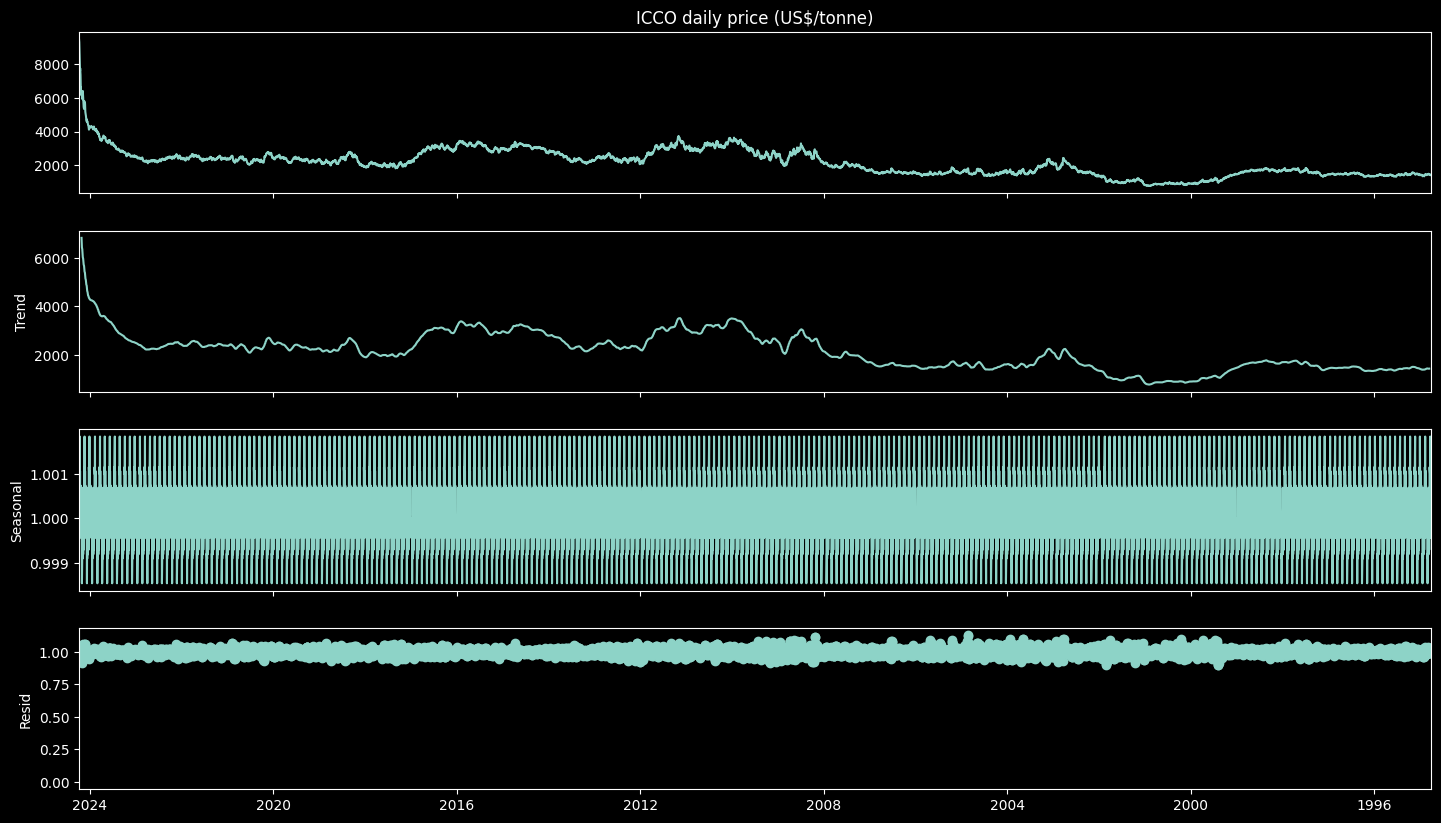

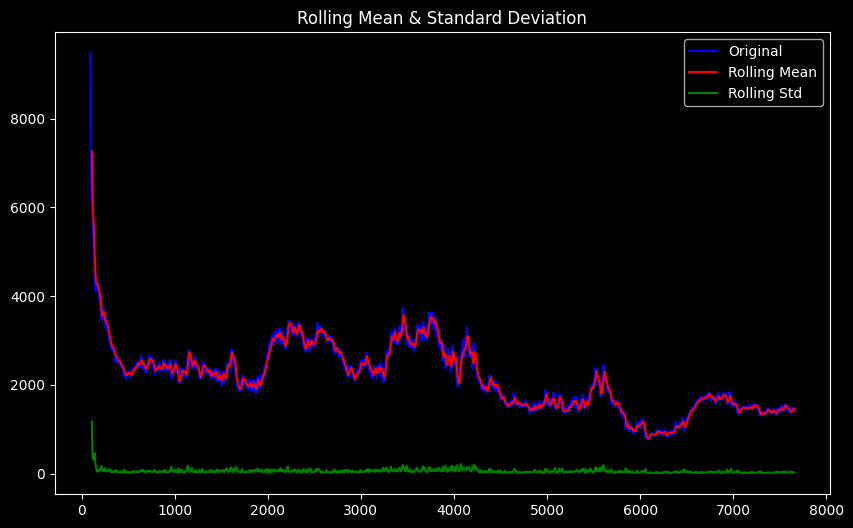

Results of Dickey-Fuller Test:
Test Statistic                -5.691525e+00
p-value                        8.050541e-07
#Lags Used                     1.100000e+01
Number of Observations Used    7.561000e+03
Critical Value (1%)           -3.431215e+00
Critical Value (5%)           -2.861922e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


In [ ]:
# Plot the ICCO daily price
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(df['Date'], df['ICCO daily price (US$/tonne)'], label='ICCO daily price (US$/tonne)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('ICCO Daily Price')
plt.legend()
plt.show()

# Seasonal decomposition
result = seasonal_decompose(df.set_index('Date')['ICCO daily price (US$/tonne)'], model='multiplicative', period=28)
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

# Test stationarity function
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Test stationarity
test_stationarity(df['ICCO daily price (US$/tonne)'])

In [ ]:
# Train-test split (70% train, 30% test)
train_size = int(len(df) * 0.70)
train_data = df[:train_size]
test_data = df[train_size:]

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data[['ICCO daily price (US$/tonne)', 'MA_7', 'MA_30', 'MA_90', 'Price_Diff', 'Volatility_7', 'Volatility_30', 'Volatility_90']])

# Prepare sequences of 100 time steps
def create_sequences(data, time_steps=100):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

time_steps = 100
x_train, y_train = create_sequences(scaled_data, time_steps)

scaled_test_data = scaler.transform(test_data[['ICCO daily price (US$/tonne)', 'MA_7', 'MA_30', 'MA_90', 'Price_Diff', 'Volatility_7', 'Volatility_30', 'Volatility_90']])
x_test, y_test = create_sequences(scaled_test_data, time_steps)

## Grid Search CV

Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'optimizer': 'adam', 'units': 50}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'optimizer': 'adam', 'units': 100}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'units': 50}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'optimizer': 'rmsprop', 'units': 100}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'optimizer': 'adam', 'units': 50}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'optimizer': 'adam', 'units': 100}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'units': 50}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'optimizer': 'rmsprop', 'units': 100}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'optimizer': 'adam', 'units': 50}
Testing parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'optimizer': 'adam', 'units': 100}
Testing parameters: {'batch_size': 32, 'dro

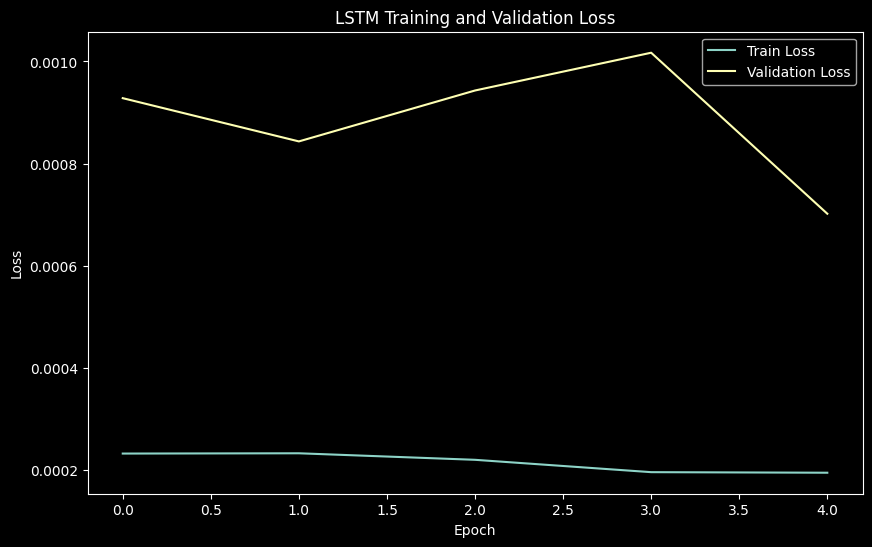

In [ ]:
# Define a simple function to create the model
def create_model(units, dropout_rate, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Define the parameter grid
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3, 0.5],
    'batch_size': [32, 64],
    'optimizer': ['adam', 'rmsprop']
}

# Create parameter combinations
grid = ParameterGrid(param_grid)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize variables to store the best configuration and its performance
best_model = None
best_score = float('inf')
best_params = None

# Loop through the grid
for params in grid:
    print(f"Testing parameters: {params}")
    model = create_model(params['units'], params['dropout_rate'], params['optimizer'])
    history = model.fit(
        x_train, y_train,
        epochs=75,
        batch_size=params['batch_size'],
        validation_data=(x_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    if val_loss < best_score:
        best_score = val_loss
        best_model = model
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_score}")

# Train the best model with early stopping
history = best_model.fit(
    x_train, y_train,
    epochs=75,
    batch_size=best_params['batch_size'],
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save The Model

In [ ]:
# Save the model
best_model.save('/content/cocoa_price_lstm_model.h5')
best_model.save('/content/drive/MyDrive/cocoa_price_lstm_model.h5')
best_model.save('/content/drive/MyDrive/FinalProjModels/cocoa_price_lstm_model.h5')

# Using native keras format
best_model.save('/content/cocoa_price_lstm_model.keras')
best_model.save('/content/drive/MyDrive/cocoa_price_lstm_model.keras')
best_model.save('/content/drive/MyDrive/FinalProjModels/cocoa_price_lstm_model.keras')


In [ ]:
# Save the preprocessed DataFrame to a CSV file
df.to_csv('/content/kobby.csv', index=False)
df.to_csv('/content/kobby.csv', index=False)

df.to_csv('/content/drive/MyDrive/FinalProjModels/kobby.csv', index=False)

In [ ]:
# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data[['ICCO daily price (US$/tonne)', 'MA_7', 'MA_30', 'MA_90', 'Price_Diff', 'Volatility_7', 'Volatility_30', 'Volatility_90']])

# Save the scaler
joblib.dump(scaler, '/content/scaler.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/FinalProjModels/scaler.pkl')


['/content/drive/MyDrive/FinalProjModels/scaler.pkl']